In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', periods=300, freq='D')

#trend component
trend = np.linspace(10, 20, 300)

#seasonality component
seasonality = 3 * np.sin(2 * np.pi * date_range.dayofyear / 7)

#random gaussian noise
noise = np.random.normal(loc=0, scale=1, size=300)

#time series = noise + seasonality + trend
data = trend + seasonality + noise
ts = pd.Series(data, index=date_range)

# 1. Creating the Training Splits

Unlike the other problems training, validation and test data should be divided *without* shuffling.

In [3]:
train = ts[:270]
test = ts[270:]

# 2. Choosing the Evaluation Metric

In time series problems, there is no consesus on which metric to use. Possible metrics:

* Mean Absolute Error
* Mean Squared Error

These metrics can be sensitive to differences in the scale or average values of the time series. Consequently, even if two models perform similarly in relative terms, the model trained on the series with larger average values will tend to exhibit higher absolute errors.

Solution:
* Mean Absolute Scale Error

* Forecast Bias: This metrics is used to evaluate the model bias rather than its accuracy. It tries to see whether the model is under predicting or overpredicting.

# 3. Forecast Methods

## 3.1. Naive Forecast

$\hat{X}_{t+1} ← X_t$

In [4]:
naive_preds = train.shift(1)

mae = mean_absolute_error(train[1:], naive_preds[1:])
mse = mean_squared_error(train[1:], naive_preds[1:])
print("MAE:", mae)
print("MSE:", mse)

MAE: 1.9378583486998027
MSE: 5.429572765877069


## 3.2. Moving Average Naive Forecast

$\hat{X}_{t+1} = \mu(X_t,X_t-1,...X_{t-p})$

In [5]:
WINDOW = 3
moving_average_preds = train.rolling(window=WINDOW).mean().dropna().values

mae = mean_absolute_error(train[WINDOW-1:], moving_average_preds)
mse = mean_squared_error(train[WINDOW-1:], moving_average_preds)
print("MAE:", mae)
print("MSE:", mse)

MAE: 1.6222153359495528
MSE: 3.503350238129291


## 3.3. Seasonal Naive Forecast

$\hat{X}_t ← X_{t-k}$

In [6]:
seasonal_naive_preds = train.shift(7)

mae = mean_absolute_error(train[7:], seasonal_naive_preds[7:])
mse = mean_squared_error(train[7:], seasonal_naive_preds[7:])
print("MAE:", mae)
print("MSE:", mse)

MAE: 1.1155635248477556
MSE: 1.9639479381855944


## 3.4. Auto Regressive Model (AR)

Assumptions:

1. $X_t$ is correlated with $X_{t-i}\quad$ $i = 1,2,3...$
2. The time series is weakly stationary ($\mu$ & $\sigma$ are constant and there is no seasonality).

To verify the stationary assumption, the Augmented Dickey Fuller test can be applied:

$H_0$: The time series is stationary.

$H_1$: The time series is not stationary.

If the time series is not stationary, getting the first difference could solve the problem. (For the reason please check this [link](https://youtu.be/oY-j2Wof51c?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&t=314))

In [7]:
#testing the assumption of white noise
train_results = adfuller(train)
print("ADF Statistic:", train_results[0])
print("p-value:", train_results[1])

ADF Statistic: -0.8902899231766085
p-value: 0.7911532643849971


In [8]:
first_diff = train.diff().dropna()
test_first_diff = test.diff().dropna()
first_diff_results = adfuller(first_diff)
print("ADF Statistic:", first_diff_results[0])
print("p-value:", first_diff_results[1])

ADF Statistic: -8.073539382713424
p-value: 1.5268156314651835e-12


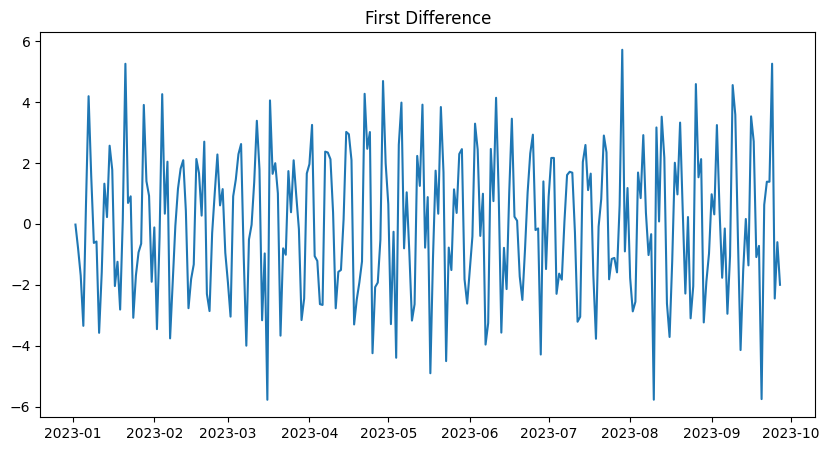

In [9]:
plt.figure(figsize = (10,5))
plt.plot(first_diff)
plt.title("First Difference")
plt.show()

### 3.4.1. Autocorrelation

* ACF between $X_t$ and $X_{t-2}$ is basically a Pearson Correlation.

* A true autocorrelation plot should based on a weakly stationary time series.

$Corr(X_t,X_{t-2})$

<Figure size 1000x500 with 0 Axes>

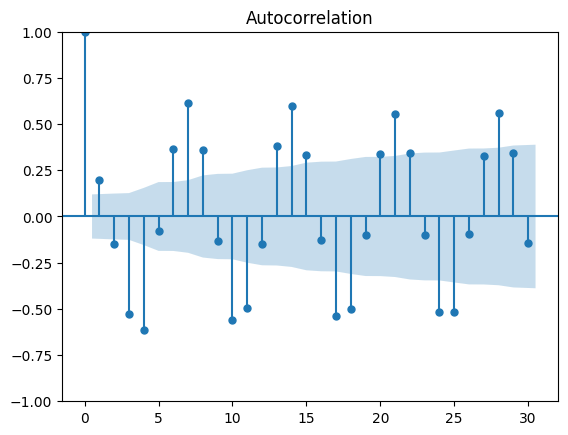

In [10]:
LAG = 30
plt.figure(figsize = (10,5))
plot_acf(first_diff, lags=LAG)
plt.show()


### 3.4.2. Patial Autocorrelation

The effect of the indirect time effects are removed from ACF. A regression model is built and the corresponding coefficient show the PACF.

$X_t = ϕ_1 X_{t-1} + ϕ_2 X_{t-2} + ɛ_t$

In this equation $ϕ_2$ shows the $PACF(X_t,X_{t-2})$

A good time series model contains only the parameters which are statistically significant (outside of the blue box).

<Figure size 1000x500 with 0 Axes>

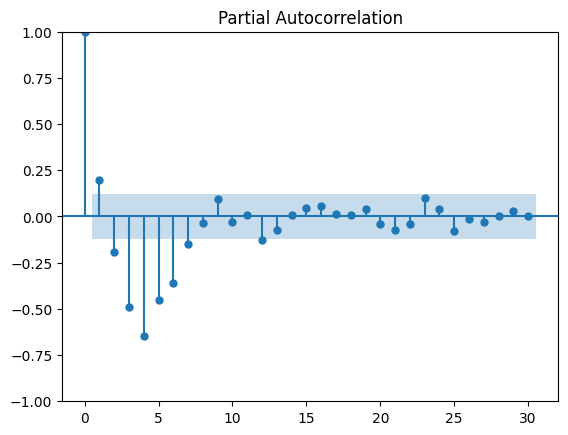

In [11]:
plt.figure(figsize = (10,5))
plot_pacf(first_diff, lags=LAG)
plt.show()

The first 5-6 lags are useful for the forecast.

### 3.4.3. The Model

$X_t = c + \gamma_1 X_{t-1} + \gamma_2 X_{t-2} + \cdots + \gamma_p X_{t-p} + \varepsilon_t$

In [12]:
LAGS = 5
ar_model = AutoReg(first_diff,lags = LAGS).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  269
Model:                     AutoReg(5)   Log Likelihood                -439.491
Method:               Conditional MLE   S.D. of innovations              1.279
Date:                Fri, 30 May 2025   AIC                            892.982
Time:                        06:51:52   BIC                            918.014
Sample:                    01-07-2023   HQIC                           903.040
                         - 09-27-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1155      0.079      1.465      0.143      -0.039       0.270
y.L1          -0.5144      0.054     -9.583      0.000      -0.620      -0.409
y.L2          -0.3304      0.041     -8.002      0.0

In [13]:
train_ar_pred = ar_model.predict(start = LAGS,end = len(first_diff)-1)
train_mae = mean_absolute_error(first_diff[LAGS:],train_ar_pred)
train_mse = mean_squared_error(first_diff[LAGS:],train_ar_pred)
print("Train MAE:",train_mae)
print("Train MSE:",train_mse)
print()

Train MAE: 1.0116222628251923
Train MSE: 1.6349296527244217



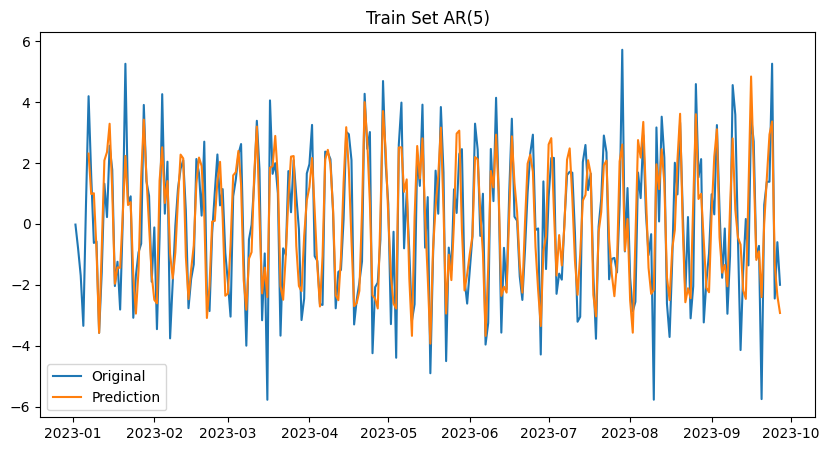

In [14]:
plt.figure(figsize = (10,5))
plt.plot(first_diff,label = "Original")
plt.plot(train_ar_pred,label = "Prediction")
plt.legend()
plt.title("Train Set AR(5)")
plt.show()

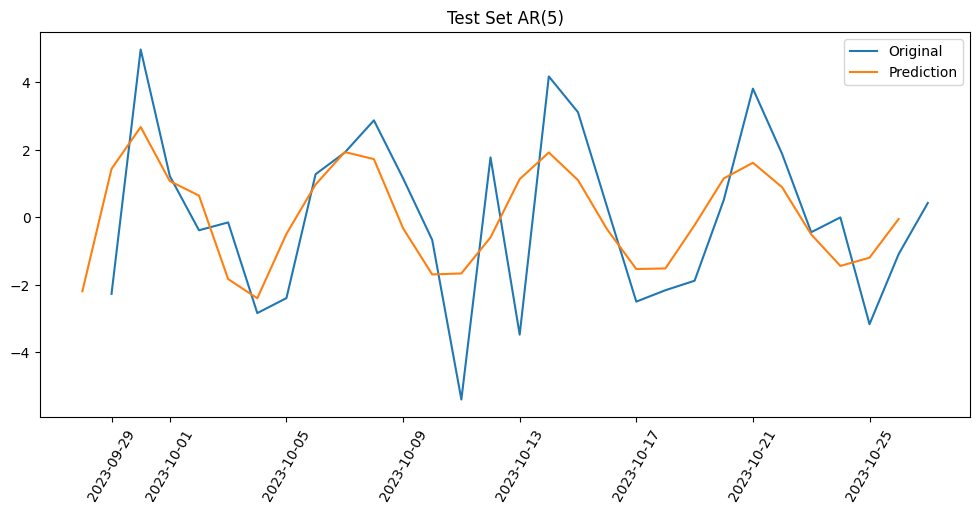

In [15]:
test_ar_pred = ar_model.predict(start = len(first_diff),end = len(first_diff) + len(test_first_diff)-1)
plt.figure(figsize = (12,5))
plt.plot(test_first_diff,label = "Original")
plt.plot(test_ar_pred,label = "Prediction")
plt.legend()
plt.title("Test Set AR(5)")
plt.xticks(rotation = 60)
plt.show()

### 3.4.4. Improving Predictions Using Rolling Window Origin

The problem with the time series predictions is that as the time stamp that needs to be predicted goes far beyond the training range, the model predictions become more uncertain. To solve this problem, the following procedure could be applied.

Procedure:

Train $X_1,...X_{k-2}\quad$; predict $X_{k-1}$

Train $X_1,...X_{k-1}\quad$; predict $X_{k}$

and so on.

This procedure is computationally more intensive but it gives more reliable results.


In [16]:
test_preds = []
history = list(first_diff)
LAGS = 5

for i in tqdm(range(len(test_first_diff))):
    model = AutoReg(history, lags=LAGS).fit()
    yhat = model.forecast(steps=1)[0]
    test_preds.append(yhat)
    history.append(test_first_diff[i])

test_ar_pred = pd.Series(test_preds, index=test_first_diff.index)

100%|██████████| 29/29 [00:00<00:00, 216.72it/s]


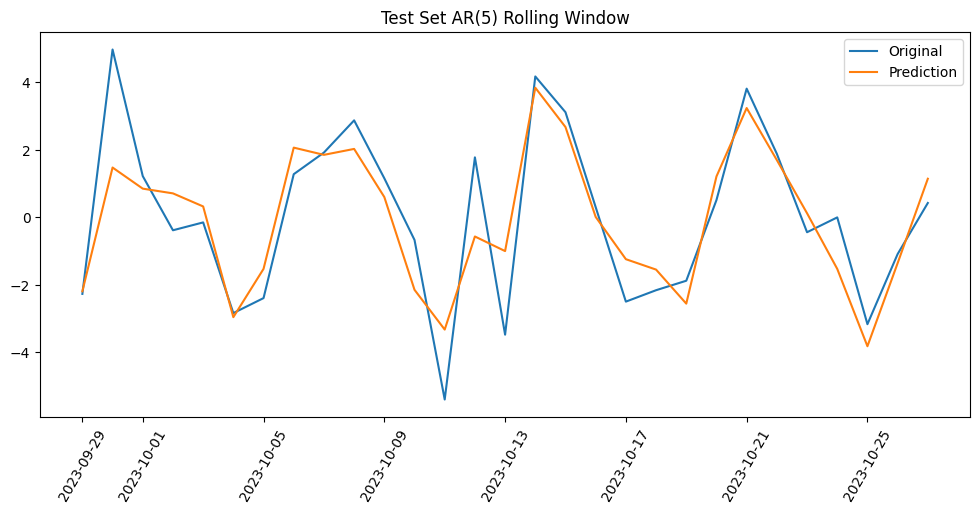

In [17]:
plt.figure(figsize = (12,5))
plt.plot(test_first_diff,label = "Original")
plt.plot(test_ar_pred,label = "Prediction")
plt.legend()
plt.title("Test Set AR(5) Rolling Window")
plt.xticks(rotation = 60)
plt.show()

## 3.6. Moving Average Model (MA)

Assumptions:

* The data is weakly stationary.

* $ɛ_t$ terms are white noise.

$E[ɛ_t] = 0$

$Var(ɛ_t) = σ^2$

$Corr(ɛ_t,ɛ_{t-k}) = 0$

* In an MA model, $X_t$ is a linear combination of past error terms:

$X_t = c + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q} + \varepsilon_t$

In [18]:
MA_LAG = 5
ma_model = ARIMA(first_diff, order = (0,0,MA_LAG)).fit()
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  269
Model:                 ARIMA(0, 0, 5)   Log Likelihood                -501.812
Date:                Fri, 30 May 2025   AIC                           1017.623
Time:                        06:51:58   BIC                           1042.786
Sample:                    01-02-2023   HQIC                          1027.729
                         - 09-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0345      0.001     38.433      0.000       0.033       0.036
ma.L1         -0.5876      0.164     -3.581      0.000      -0.909      -0.266
ma.L2         -0.5229      0.080     -6.541      0.0

In [19]:
train_ma_pred = ma_model.predict(start = MA_LAG, end = len(first_diff)-1)
mae = mean_absolute_error(first_diff[MA_LAG:],train_ma_pred)
mse = mean_squared_error(first_diff[MA_LAG:],train_ma_pred)
print("Train MAE:",mae)
print("Train MSE:",mse)

test_ma_pred = ma_model.predict(start = len(first_diff), end = len(first_diff) + len(test_first_diff)-1)
mae = mean_absolute_error(test_first_diff,test_ma_pred)
mse = mean_squared_error(test_first_diff,test_ma_pred)
print()
print("Validation MAE:",mae)
print("Validation MSE:",mse)

Train MAE: 1.2744091441017338
Train MSE: 2.4135250522248053

Validation MAE: 1.9774176561064194
Validation MSE: 5.6739837616665625


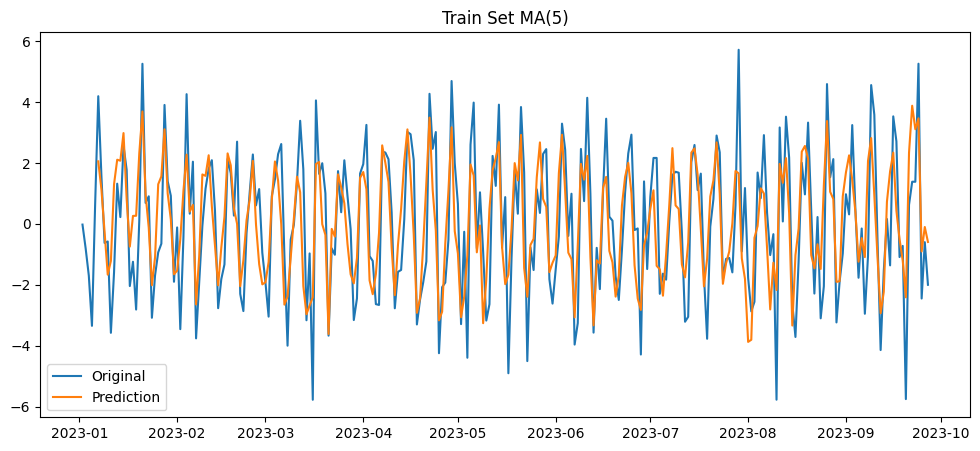

In [20]:
plt.figure(figsize=(12,5))
plt.plot(first_diff, label='Original')
plt.plot(train_ma_pred, label='Prediction')
plt.legend()
plt.title("Train Set MA(5)")
plt.show()

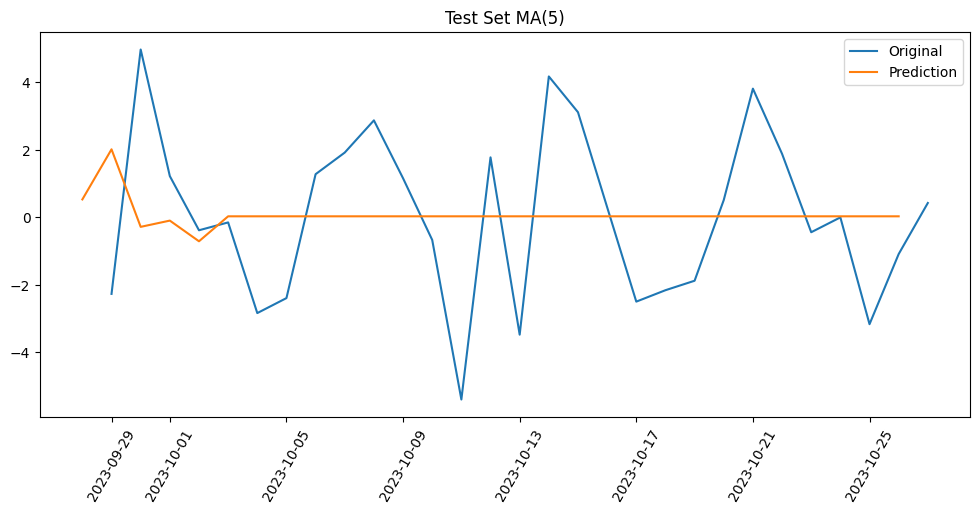

In [21]:
plt.figure(figsize=(12,5))
plt.plot(test_first_diff, label='Original')
plt.plot(test_ma_pred, label='Prediction')
plt.legend()
plt.title("Test Set MA(5)")
plt.xticks(rotation = 60)
plt.show()

### 3.6.1. Rolling Window Origin for MA Model

In [22]:
history = list(first_diff)
test_preds = []
for i in tqdm(range(len(test_first_diff))):
    model = ARIMA(history, order=(0, 0, MA_LAG)).fit()
    yhat = model.forecast(steps=1)[0]
    test_preds.append(yhat)
    history.append(test_first_diff[i])

test_ma_pred = pd.Series(test_preds, index=test_first_diff.index)
mae = mean_absolute_error(test_first_diff,test_ma_pred)
mse = mean_squared_error(test_first_diff,test_ma_pred)
print()
print("Validation MAE:",mae)
print("Validation MSE:",mse)

100%|██████████| 29/29 [00:44<00:00,  1.55s/it]


Validation MAE: 1.4177460911531548
Validation MSE: 2.7946910022503846


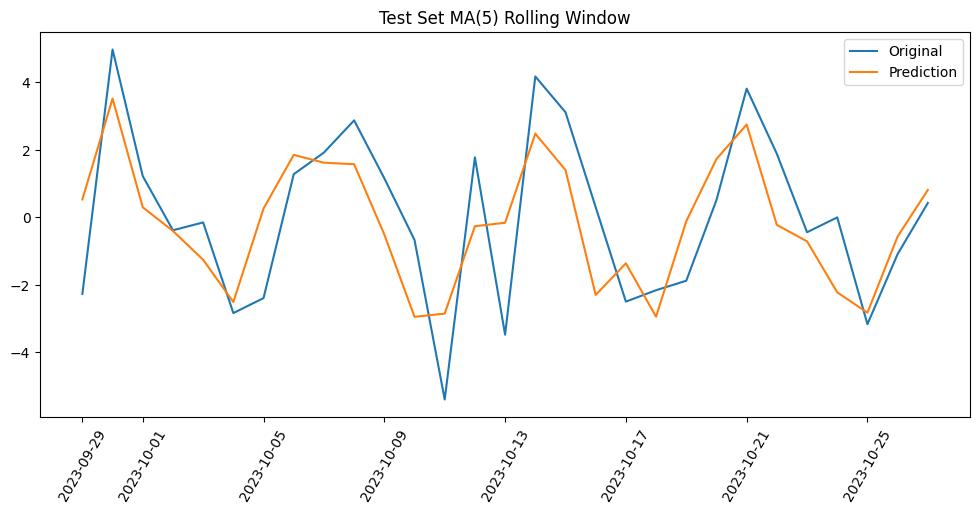

In [23]:
plt.figure(figsize=(12,5))
plt.plot(test_first_diff, label='Original')
plt.plot(test_ma_pred, label='Prediction')
plt.legend()
plt.title("Test Set MA(5) Rolling Window")
plt.xticks(rotation = 60)
plt.show()

....
## 3.7. ARMA Model


Model equation:

$X_t = c + \sum_{i=1}^p \gamma_i X_{t-i} + \varepsilon_t + \sum_{j=1}^q \theta_j \varepsilon_{t-j}
$

How to decide the order of AR and MA?

As a heuristic, the number of significant features appeared in ACF can be used for MA and PACF for AR ([Link](https://youtu.be/HhvTlaN06AM?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&t=306)).

In [24]:
LAG = 3
MA_LAG = 1
arma_model = ARIMA(first_diff, order = (LAG,0,MA_LAG)).fit()
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  269
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -460.253
Date:                Fri, 30 May 2025   AIC                            932.506
Time:                        06:52:45   BIC                            954.074
Sample:                    01-02-2023   HQIC                           941.168
                         - 09-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0342      0.001     25.824      0.000       0.032       0.037
ar.L1          0.4538      0.050      9.057      0.000       0.356       0.552
ar.L2         -0.1223      0.059     -2.071      0.0

In [25]:
arma_pred = arma_model.predict(start = MA_LAG, end = len(first_diff)-1)
mae = mean_absolute_error(first_diff[MA_LAG:],arma_pred)
mse = mean_squared_error(first_diff[MA_LAG:],arma_pred)
print("Train MAE:",mae)
print("Train MSE:",mse)

predictions = []
history = list(first_diff)
for i in tqdm(range(len(test_first_diff))):
    model = ARIMA(history[-LAG:], order=(LAG, 0, MA_LAG)).fit()
    yhat = model.forecast(steps = 1)[0]
    predictions.append(yhat)
    history.append(test_first_diff[i])

test_arma_pred = pd.Series(predictions, index=test_first_diff.index)
mae = mean_absolute_error(test_first_diff,test_arma_pred)
mse = mean_squared_error(test_first_diff,test_arma_pred)
print()
print("Validation MAE:",mae)
print("Validation MSE:",mse)


Train MAE: 1.0852218227982398
Train MSE: 1.7966561051429313


100%|██████████| 29/29 [00:07<00:00,  3.68it/s]


Validation MAE: 4.762378204710517
Validation MSE: 28.990328573235875


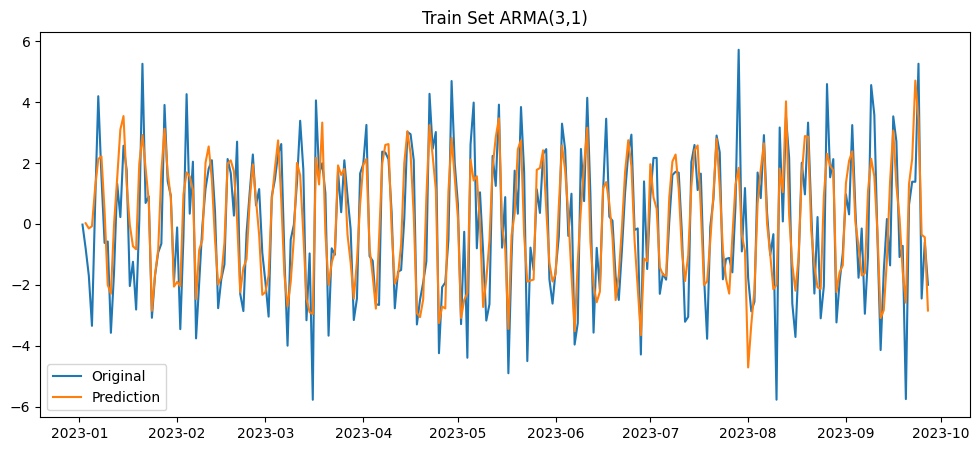

In [26]:
plt.figure(figsize=(12,5))
plt.plot(first_diff, label='Original')
plt.plot(arma_pred, label='Prediction')
plt.legend()
plt.title("Train Set ARMA(3,1)")
plt.show()

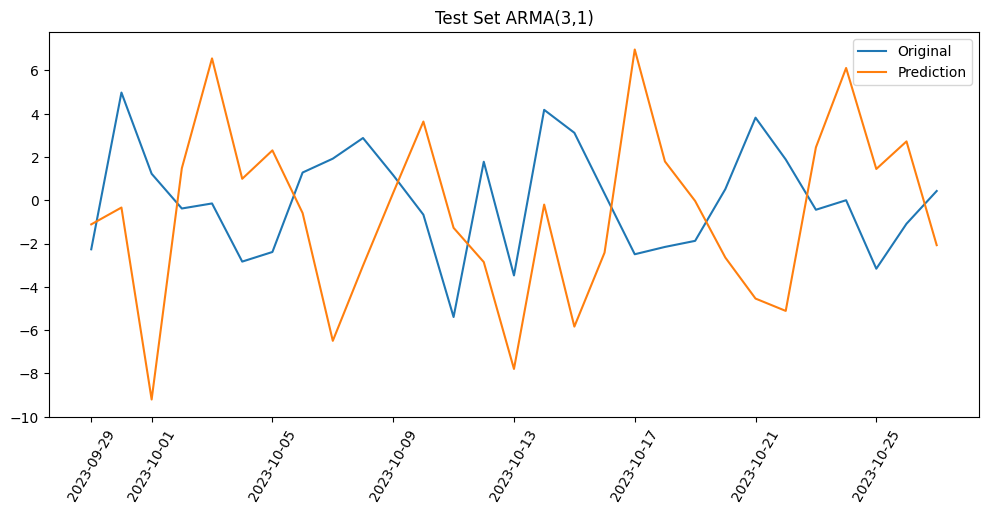

In [27]:
plt.figure(figsize=(12,5))
plt.plot(test_first_diff, label='Original')
plt.plot(test_arma_pred, label='Prediction')
plt.legend()
plt.title("Test Set ARMA(3,1)")
plt.xticks(rotation = 60)
plt.show()